![](imagegeneratedbyai.png)

Imagine living in a house where every single watt of electricity you use is meticulously recorded, each of which contributes to a vast pool of data. By analyzing this detailed household power consumption data recorded over nearly 4 years, an energy company can help customers achieve sustainable energy usage while balancing their energy generation. With predictive models, the company can optimize energy usage, forecast future consumption, and provide tailored recommendations. My task is to use this dataset to build a model that predicts power consumption, benefiting both the energy provider and its customers.

## The Data

Available in `df_train.csv` and `df_test.csv`:

| Column             | Type   | Description                                                                 |
|--------------------|--------|----------------------------------------------------------------------------|
| date               | chr    | Date of the measurement                                                    |
| power_consumption  | dbl    | Daily power consumption (in kilowatts)                                     |
| year               | int    | Year of the measurement                                                    |
| semester           | int    | Semester of the measurement (1 for Jan-Jun, 2 for Jul-Dec)                 |
| quarter            | int    | Quarter of the measurement (1 for Q1, 2 for Q2, 3 for Q3, 4 for Q4)        |
| day_in_week        | chr    | Day of the week of the measurement (e.g., Monday, Tuesday)                 |
| week_in_year       | int    | Week number in the year of the measurement                                 |
| day_in_year        | int    | Day number in the year of the measurement                                  |
| month              | int    | Month of the year of the measurement                                       |

This dataset was donated to the UCI Machine Learning Repository. For detailed information about the dataset and the preprocessing steps, please refer to the [License and Data Preprocessing Details](License.ipynb) notebook.

In [2]:
# Load necessary libraries
suppressPackageStartupMessages(library(dplyr))
library(lubridate) 
library(ranger)    
library(xgboost)   
library(ggplot2)   

# Load and inspect the training and testing datasets
df_train <- read.csv("df_train.csv")
df_test <- read.csv("df_test.csv")

## Explore the structure of the dataset
glimpse(df_train)

# Start coding here...add as many cells as you like!

Rows: 1,202
Columns: 9
$ date              <chr> "12/16/2006", "12/17/2006", "12/18/2006", "12/19/200…
$ power_consumption <dbl> 1209.176, 3390.460, 2203.826, 1666.194, 2225.748, 17…
$ year              <int> 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006…
$ semester          <int> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1…
$ quarter           <int> 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1…
$ day_in_week       <chr> "Sat", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sa…
$ week_in_year      <int> 50, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, …
$ day_in_year       <int> 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 36…
$ month             <int> 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, …


Rows: 1,202
Columns: 9
$ date              <chr> "12/16/2006", "12/17/2006", "12/18/2006", "12/19/200…
$ power_consumption <dbl> 1209.176, 3390.460, 2203.826, 1666.194, 2225.748, 17…
$ year              <int> 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006…
$ semester          <int> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1…
$ quarter           <int> 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1…
$ day_in_week       <chr> "Sat", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sa…
$ week_in_year      <int> 50, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, …
$ day_in_year       <int> 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 36…
$ month             <int> 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, …


Warning message in predict.lm(lm_model, newdata = test_x):
“prediction from a rank-deficient fit may be misleading”


Model,RMSE
<chr>,<dbl>
Linear Regression,504.2986
Random Forest,392.7622
XGBoost,403.5540


selected_rmse: 392.7622 kW
trend_similarity: Yes 


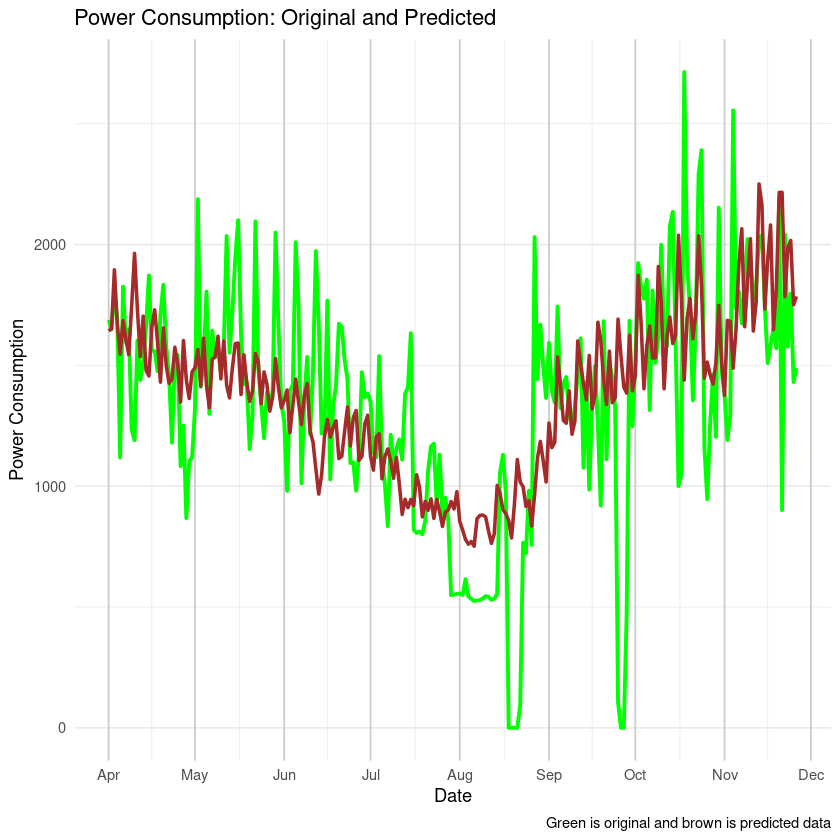

In [3]:
# Load necessary libraries
library(dplyr)     
library(lubridate) 
library(ranger)    
library(xgboost)   
library(ggplot2)   

# Read training and testing data from CSV files
df_train <- read.csv("df_train.csv")
df_test <- read.csv("df_test.csv")

# Display structure of the training data
glimpse(df_train)

# Convert 'date' column to Date type and 'day_in_week' column to factor in both datasets
df_train <- df_train %>%
  mutate(date = as.Date(date, format = "%m/%d/%Y"),
         day_in_week = factor(day_in_week)) 
df_test <- df_test %>%
  mutate(date = as.Date(date, format = "%m/%d/%Y"),
         day_in_week = factor(day_in_week))

# Convert categorical variable 'day_in_week' to indicator variables using one-hot encoding in both datasets
df_onehot_train <- model.matrix(~ day_in_week - 1, data = df_train) %>%
  as.data.frame()
df_onehot_test <- model.matrix(~ day_in_week - 1, data = df_test) %>%
  as.data.frame()

# Combine one-hot encoded columns with the original datasets and remove the 'day_in_week' column
df_train <- mutate(df_train, df_onehot_train) %>% select(-c(day_in_week))
df_test <- mutate(df_test, df_onehot_test) %>% select(-c(day_in_week))

# Separate features and target variable for both training and testing datasets
train_x <- df_train %>% select(-power_consumption, -date)  
train_y <- df_train[["power_consumption"]]  
test_x <- df_test %>% select(-power_consumption, -date)  
test_y <- df_test[["power_consumption"]]  

# Train models, predict on test dataset and calculate RMSE for each model.
## Linear regression
lm_model <- lm(train_y ~ ., data = train_x)   
lm_pred <- predict(lm_model, newdata = test_x)  
lm_rmse <- sqrt(mean((test_y - lm_pred)^2))  

## Random forest
rf_model <- ranger(power_consumption ~., data = df_train %>% select(-date), num.trees = 1000)
rf_pred <- predict(rf_model, data = df_test %>% select(-date))$predictions  
rf_rmse <- sqrt(mean((test_y - rf_pred)^2))  

## XGBoost
xgb_model <- xgboost(
  data = as.matrix(train_x),  
  label = train_y,  
  nrounds = 500, 
  objective = "reg:squarederror",  
  eta = 0.1,  
  max_depth = 1,  
  verbose = FALSE
)
xgb_pred <- predict(xgb_model, newdata = as.matrix(test_x))  
xgb_rmse <- sqrt(mean((test_y - xgb_pred)^2))  

# RMSE scores
data.frame(
  Model = c("Linear Regression", "Random Forest", "XGBoost"),  
  RMSE = c(lm_rmse, rf_rmse, xgb_rmse)  
)

# Get the lowest RMSE and assign it to selected_rmse
selected_rmse <- min(lm_rmse, rf_rmse, xgb_rmse)
cat("selected_rmse:", selected_rmse, "kW\n")

# Add predictions to the test dataset for plotting
df_test <- df_test %>%
  mutate(Predicted = rf_pred)

# Plot actual vs predicted power consumption over time to check for trend similarity
ggplot(df_test) +
  geom_line(aes(x = date, y = power_consumption), color = "green", linewidth = 1.1) +
  geom_line(aes(x = date, y = Predicted), color = "brown", linewidth = 1) +
  labs(title = "Power Consumption: Original and Predicted", x = "Date", y = "Power Consumption", caption = "Green is original and brown is predicted data") +
  scale_x_date(date_breaks = "1 month", date_labels = "%b") +
  theme_minimal() +
  theme(panel.grid.major.x = element_line(color = "grey80"))

trend_similarity <- "Yes"

cat("trend_similarity:", trend_similarity, "\n")